# Diabetes Progression Prediction — Machine Learning Lab

**Dataset:** Scikit-Learn Diabetes Dataset  
**Objective:** Build and evaluate machine learning models to predict diabetes disease progression one year after baseline, to be used as a clinical screening tool for physicians.

---

## Part 1 — Problem Framing, EDA & Data Preparation

### Step 1 — Load the Data

In [1]:
# ── Imports ───────────────────────────────────────────────────────────────────
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import (
    r2_score, mean_absolute_error,
    mean_absolute_percentage_error,
    accuracy_score, classification_report
)
from sklearn.pipeline import Pipeline

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 100

# ── Load dataset ──────────────────────────────────────────────────────────────
diabetes = datasets.load_diabetes(as_frame=True, scaled=False)
df = diabetes.frame
feature_cols = list(diabetes.feature_names)

print("Shape:", df.shape)
df.head()

# ── Output folder for all figures ────────────────────────────────────────────
import os
FIGURES_DIR = 'figures'
os.makedirs(FIGURES_DIR, exist_ok=True)
print(f"Figures will be saved to: {os.path.abspath(FIGURES_DIR)}")


Shape: (442, 11)
Figures will be saved to: c:\Users\bhatt\Downloads\diabetes_project_final\Practical Lab 2\figures


In [2]:
# ── Display-friendly copy (EDA / visualisation only — df unchanged for modelling) ──
df_display = df.copy()
df_display['sex'] = df_display['sex'].map({1.0: 'Female', 2.0: 'Male'})
df_display.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,Male,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,Female,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,Male,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,Female,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,Female,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


---

### Step 2 — Frame the Problem

#### 2.1 Task Type — Regression vs Classification

This is a **supervised regression** problem. The target variable — a quantitative measure of **diabetes disease progression one year after baseline** — is a **continuous numerical value** ranging from 25 to 346. Because the output is continuous, regression is the appropriate framework:

- **Regression** predicts a continuous output (e.g., a progression score of 187.4)
- **Classification** predicts a discrete class label (e.g., "high risk" vs "low risk")

In **Part 3**, we also explore a classification framing: we **binarise** the target at its median, labelling patients above the median as *high-risk (1)* and below as *low-risk (0)*. This allows us to apply Logistic Regression and produce clinically actionable risk probabilities. This binary framing trades precision of the progression estimate for interpretability as a screening flag.

#### 2.2 Clinical Motivation

Early identification of patients at elevated risk of disease progression enables physicians to intervene proactively — through lifestyle modifications, medication adjustment, or closer monitoring. A well-calibrated predictive model can serve as a **first-line screening tool** that surfaces high-risk patients from routine lab and physical examination data, without requiring expensive or invasive testing.

#### 2.3 Why R², MAE, and MAPE?

No single metric tells the full story. We use three complementary measures:

**R² (Coefficient of Determination)**  
R² measures the **proportion of variance** in the target that is explained by the model, on a scale from 0 to 1 (where 1 is a perfect fit and 0 means the model performs no better than simply predicting the mean). It gives a quick global summary of model quality, but it does not directly convey the magnitude of errors in clinically meaningful units.

**MAE (Mean Absolute Error)**  
MAE is the **average absolute difference** between predictions and actual values, expressed in the same units as the target (disease progression score). It is robust to outliers — a single extreme prediction does not dominate the metric. This makes it clinically interpretable: an MAE of 40 means our model is wrong by an average of 40 progression units per patient.

**MAPE (Mean Absolute Percentage Error)**  
MAPE expresses prediction error as a **percentage of the actual value**, enabling comparison of error magnitude across patients with very different baseline scores. However, MAPE has a critical weakness in medical contexts: **when actual values are small (close to zero), the denominator shrinks and MAPE can become extremely large or even undefined** — inflating the apparent error rate for low-risk patients. This instability makes MAPE a secondary metric here, interpreted alongside MAE rather than in isolation.

#### 2.4 Train / Validation / Test Strategy

We apply a **three-way split** (75% train, 10% validation, 15% test):
- **Training set:** Used exclusively for fitting model parameters.
- **Validation set:** Used for hyperparameter and degree selection (e.g., choosing the best polynomial degree). Never used for fitting.
- **Test set:** Used exactly once, at the very end, to report final unbiased performance. Consulting test metrics during model selection constitutes data leakage.

#### 2.5 Workshop Talking Points

- *Performance Metrics workshop:* In classification, we use confusion matrices, precision, recall, and ROC-AUC. In a screening context, **false negatives** (high-risk patients labelled low-risk) are **more dangerous** than false positives — a patient incorrectly cleared may miss critical early intervention. This asymmetry should influence the choice of threshold when converting regression scores to risk classes.
- *KNN workshop:* KNN is a non-parametric method — it makes no assumptions about the functional form of the relationship. The key hyperparameter `k` controls the bias-variance tradeoff: small `k` → low bias, high variance (memorises training data); large `k` → high bias, low variance (overly smooth predictions).
- *Logistic Regression workshop:* Logistic regression models the log-odds of class membership and outputs calibrated probabilities — ideal for screening. The regularisation parameter `C` (inverse of regularisation strength) controls overfitting. Accuracy alone is insufficient; in imbalanced medical data, precision and recall must also be examined.

---

### Step 3 — Exploratory Data Analysis (EDA)

#### 3a. Descriptive Statistics

In [3]:
print(f"Dataset dimensions : {df.shape[0]} samples × {df.shape[1]} columns")
print(f"Features           : {feature_cols}")
print(f"Target             : 'target' — quantitative disease progression (1 year post-baseline)")
print(f"Missing values     : {df.isnull().sum().sum()}")
print(f"Duplicate rows     : {df.duplicated().sum()}")
print()
df.describe().round(2)

Dataset dimensions : 442 samples × 11 columns
Features           : ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
Target             : 'target' — quantitative disease progression (1 year post-baseline)
Missing values     : 0
Duplicate rows     : 0



,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00
mean,48.52,1.47,26.38,94.65,189.14,115.44,49.79,4.07,4.64,91.26,152.13
std,13.11,0.50,4.42,13.83,34.61,30.41,12.93,1.29,0.52,11.50,77.09
min,19.00,1.00,18.00,62.00,97.00,41.60,22.00,2.00,3.26,58.00,25.00
25%,38.25,1.00,23.20,84.00,164.25,96.05,40.25,3.00,4.28,83.25,87.00
50%,50.00,1.00,25.70,93.00,186.00,113.00,48.00,4.00,4.62,91.00,140.50
75%,59.00,2.00,29.28,105.00,209.75,134.50,57.75,5.00,5.00,98.00,211.50
max,79.00,2.00,42.20,133.00,301.00,242.40,99.00,9.09,6.11,124.00,346.00


**Key observations from descriptive statistics:**

- The dataset contains **442 samples** — a relatively **small dataset** for machine learning. This raises an immediate **overfitting risk**: complex models with many parameters (e.g., degree-3 polynomial with 10 features = 286 terms) will easily memorise the training data without generalising.
- All features are numeric (float64). There are **no missing values**, which simplifies the preprocessing pipeline considerably.
- The **target** ranges from 25 to 346, with a mean of ~152 and standard deviation of ~77, indicating wide variability in disease progression across patients.
- **BMI** spans 18 to 42, covering underweight to morbidly obese patients — a clinically meaningful range.
- **sex** takes only two values (1.0 = Female, 2.0 = Male) — it is effectively a binary categorical variable encoded as numeric.
- Note that in the **unscaled** version of the dataset (which we use here), features retain their original clinical units. The scaled version (default) standardises all features to have zero mean and unit variance — useful for distance-based methods like KNN.

#### 3b. Target Variable Distribution

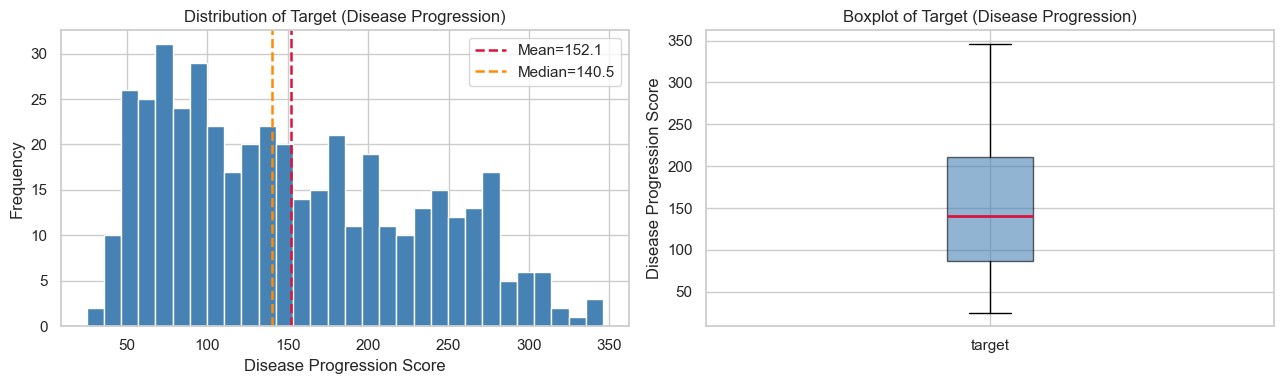

Skewness : 0.441
Kurtosis : -0.883
Mean     : 152.1
Median   : 140.5


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].hist(df['target'], bins=30, color='steelblue', edgecolor='white')
axes[0].axvline(df['target'].mean(),   color='crimson',    linestyle='--', linewidth=1.8, label=f"Mean={df['target'].mean():.1f}")
axes[0].axvline(df['target'].median(), color='darkorange', linestyle='--', linewidth=1.8, label=f"Median={df['target'].median():.1f}")
axes[0].set_title('Distribution of Target (Disease Progression)', fontsize=12)
axes[0].set_xlabel('Disease Progression Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()

axes[1].boxplot(df['target'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='steelblue', alpha=0.6),
                medianprops=dict(color='crimson', linewidth=2))
axes[1].set_title('Boxplot of Target (Disease Progression)', fontsize=12)
axes[1].set_ylabel('Disease Progression Score')
axes[1].set_xticklabels(['target'])

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'target_distribution.png'), bbox_inches='tight')
plt.show()

print(f"Skewness : {df['target'].skew():.3f}")
print(f"Kurtosis : {df['target'].kurt():.3f}")
print(f"Mean     : {df['target'].mean():.1f}")
print(f"Median   : {df['target'].median():.1f}")

**Insights:**
- The target is **right-skewed** (skewness > 0), meaning the majority of patients have lower progression scores, with a tail of high-progression outliers.
- The **mean (152) is slightly above the median (140)**, confirming the right skew — a small group of patients with very high progression pulls the mean upward.
- The boxplot reveals several **upper outliers** (patients with progression > ~300). These represent genuinely extreme cases and should be retained — in a medical dataset, outlier patients are often precisely the high-risk individuals the screening tool is designed to flag.
- The right skew also implies that **MAPE will be unstable for low-progression patients** (small denominators), reinforcing why we report MAE alongside MAPE.

#### 3c. Feature Distributions (Histograms)

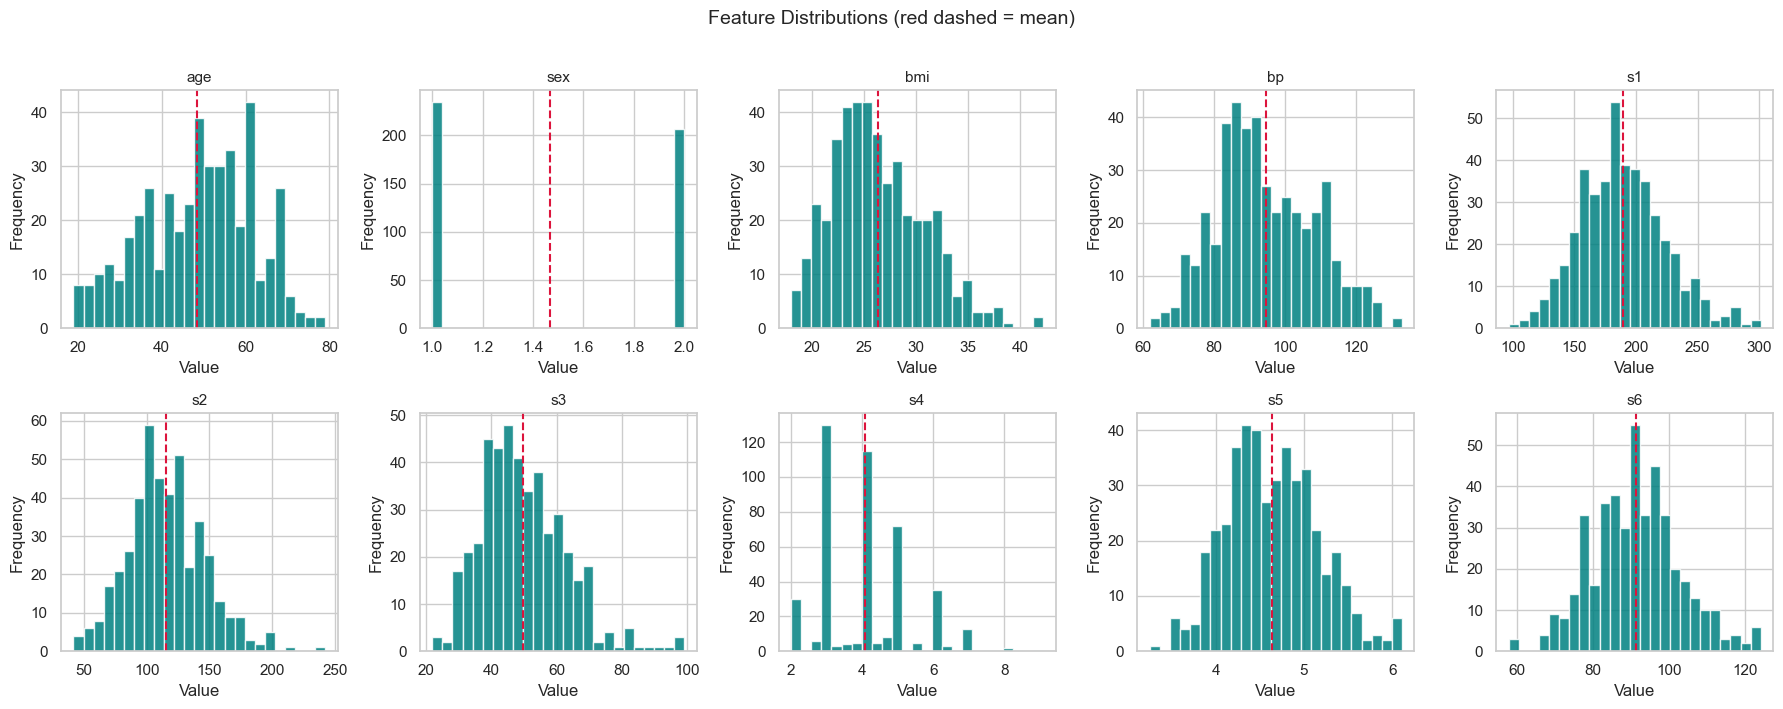

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    axes[i].hist(df[col], bins=25, color='teal', edgecolor='white', alpha=0.85)
    axes[i].axvline(df[col].mean(), color='crimson', linestyle='--', linewidth=1.5)
    axes[i].set_title(col, fontsize=11)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.suptitle('Feature Distributions (red dashed = mean)', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'feature_histograms.png'), bbox_inches='tight')
plt.show()

**Insights:**
- Most features are **approximately normally distributed** — age, BMI, BP, and most serum measures are roughly bell-shaped, which is favourable for linear and polynomial models.
- **sex** is clearly **bimodal/binary** — it takes only two distinct values (1.0 and 2.0), reflecting its categorical nature despite numeric encoding.
- **S1 (total cholesterol) and S2 (LDL)** are slightly right-skewed — consistent with population-level clinical observations where a minority of patients have very high cholesterol.
- No feature shows an extreme multi-modal or heavily skewed distribution that would require transformation prior to linear modelling.

#### 3d. Scatter Plots — Each Feature vs Target

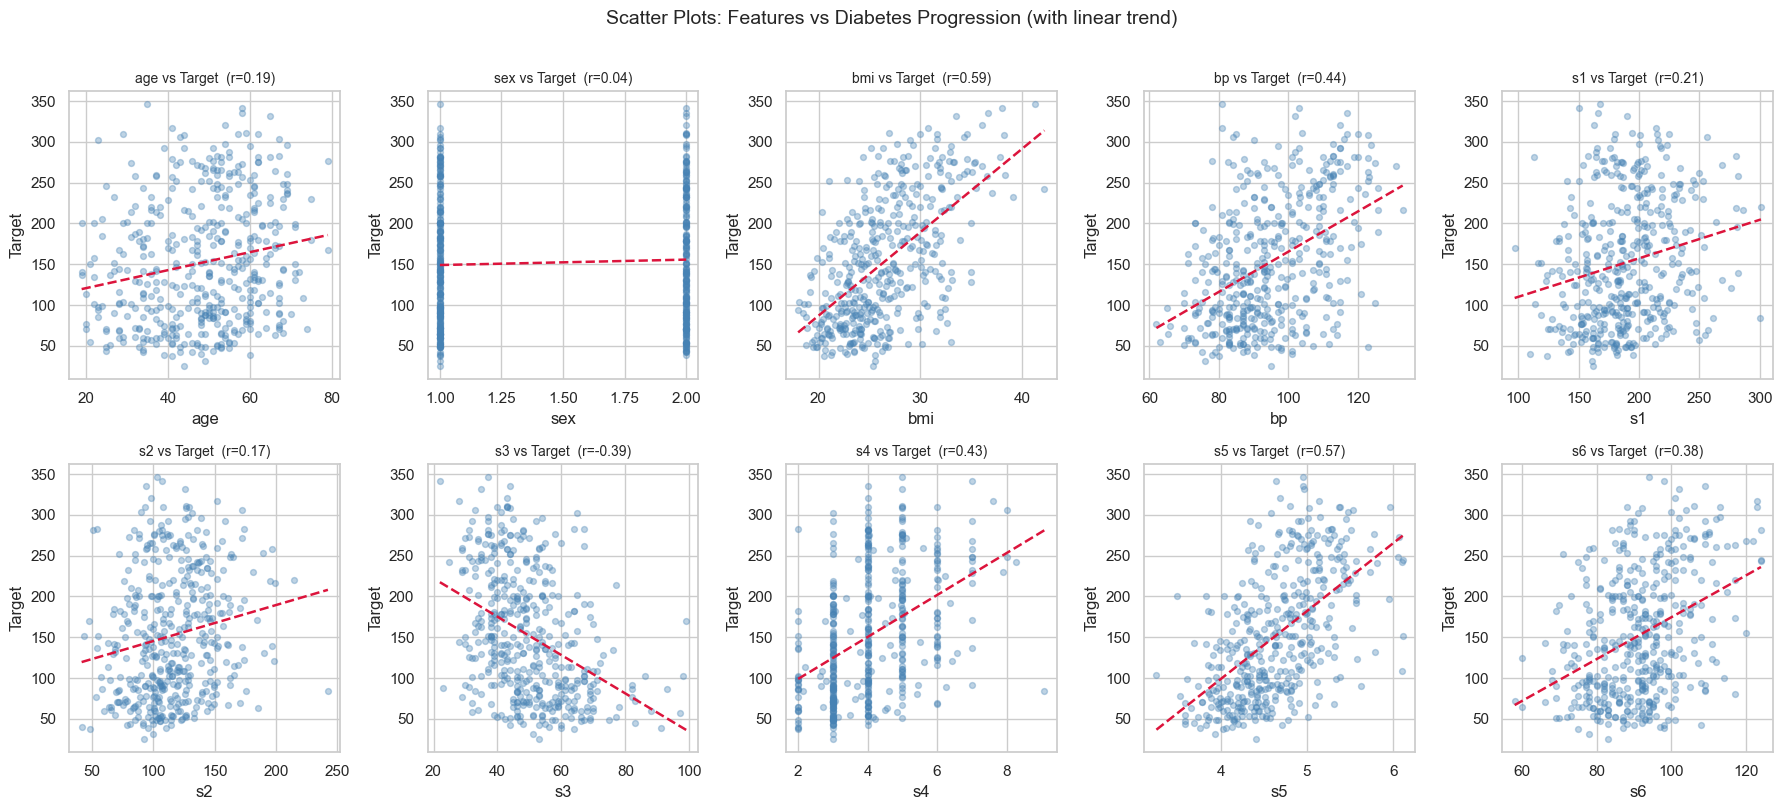

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    axes[i].scatter(df[col], df['target'], alpha=0.35, s=18, color='steelblue')
    # Add trend line
    z = np.polyfit(df[col], df['target'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df[col].min(), df[col].max(), 100)
    axes[i].plot(x_line, p(x_line), color='crimson', linewidth=1.8, linestyle='--')
    corr_val = df[col].corr(df['target'])
    axes[i].set_title(f'{col} vs Target  (r={corr_val:.2f})', fontsize=10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Target')

plt.suptitle('Scatter Plots: Features vs Diabetes Progression (with linear trend)', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'scatter_plots.png'), bbox_inches='tight')
plt.show()

**Insights:**

- **BMI (r = 0.59)** has the **strongest positive linear relationship** with the target. As BMI increases, disease progression increases. This motivates using BMI as the single feature for univariate modelling in Part 2.
- **S5/LTG (r = 0.57)** — the log of serum triglycerides — is almost equally predictive as BMI, showing a strong positive trend. This is clinically expected: elevated triglycerides are a known diabetes risk factor.
- **BP (r = 0.44)** shows a moderate positive trend, also consistent with clinical literature linking hypertension to metabolic disease.
- **S3/HDL (r = −0.40)** shows a **negative correlation**: higher HDL ("good cholesterol") is associated with lower disease progression — clinically meaningful and protective.
- **sex** and **age** show weak linear relationships with the target, though they may contribute in combination with other features in multivariate models.
- Several scatter plots (particularly BMI and S5) show **non-linear spread** — the variance of the target increases at higher feature values. This heteroscedasticity (non-constant variance) suggests that linear models may underperform and that polynomial terms or non-linear models could improve fit.
- Some features with **weak individual correlations** (e.g., S1, S2) may still contribute meaningfully in combination — motivating the use of all features in Part 3.

#### 3e. Correlation Matrix

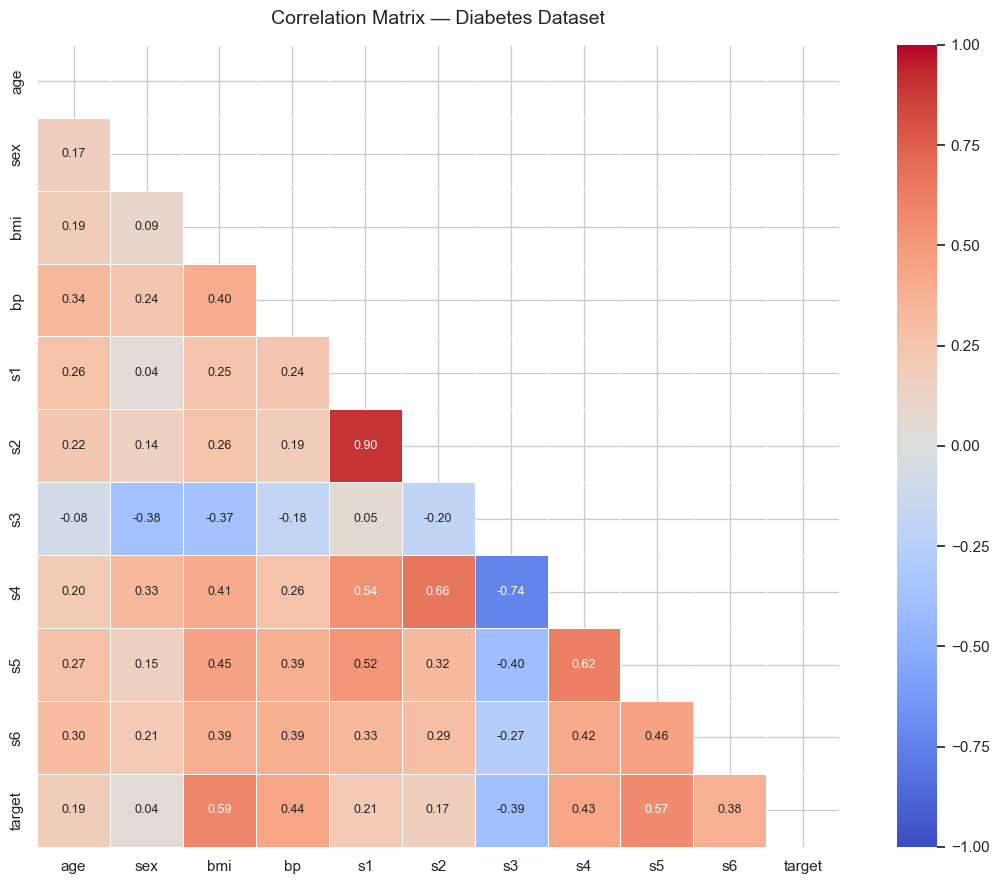


Correlations with Target (sorted):
bmi    0.59
s5     0.57
bp     0.44
s4     0.43
s6     0.38
s1     0.21
age    0.19
s2     0.17
sex    0.04
s3    -0.39
Name: target, dtype: float64


In [7]:
corr = df.corr().round(2)

plt.figure(figsize=(12, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
    linewidths=0.5, vmin=-1, vmax=1, square=True, annot_kws={'size': 9}
)
plt.title('Correlation Matrix — Diabetes Dataset', fontsize=14, pad=15)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'correlation_matrix.png'), bbox_inches='tight')
plt.show()

print("\nCorrelations with Target (sorted):")
print(corr['target'].drop('target').sort_values(ascending=False))

**Insights from the correlation matrix:**

- **BMI (r = 0.59)** and **S5 (r = 0.57)** are the **two strongest predictors** of diabetes progression. Any effective model should leverage these features.
- **S3/HDL (r = −0.40)** is the only feature with a meaningful **negative** correlation — its protective effect should be captured by the model.
- **Critical concern — Multicollinearity:** S1 and S2 are **extremely highly correlated** (r ≈ 0.90). Including both in a linear/polynomial regression model creates multicollinearity, which inflates coefficient variance and makes individual coefficient estimates unreliable. This does not affect prediction accuracy directly but destabilises the model equation.
- S1 is also strongly correlated with S3 (r ≈ −0.66) and S4 (r ≈ 0.54), forming a cluster of inter-correlated serum measurements.
- **sex** has the weakest correlation with the target (r = 0.04), suggesting it adds little predictive value on its own — though it may interact with other features (e.g., BMI × sex).
- The correlation matrix confirms that **no single feature perfectly predicts progression**, which is why multivariate models are expected to outperform the univariate BMI model.

#### 3f. Sex Distribution

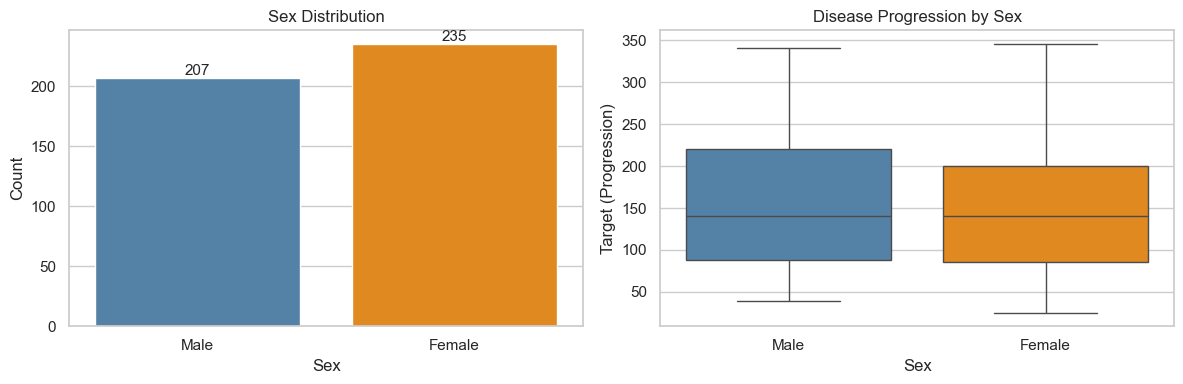

Mean progression by sex:
        count    mean    std   min   25%    50%    75%    max
sex                                                          
Female  235.0  149.02  75.91  25.0  85.5  140.0  200.0  346.0
Male    207.0  155.67  78.45  39.0  88.0  141.0  220.5  341.0


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
sns.countplot(data=df_display, x='sex', ax=axes[0],
              palette=['steelblue', 'darkorange'])
axes[0].set_title('Sex Distribution', fontsize=12)
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Count')
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width()/2, p.get_height()),
                     ha='center', va='bottom', fontsize=11)

# Box plot: target by sex
sns.boxplot(data=df_display, x='sex', y='target', ax=axes[1],
            palette=['steelblue', 'darkorange'])
axes[1].set_title('Disease Progression by Sex', fontsize=12)
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Target (Progression)')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'sex_distribution.png'), bbox_inches='tight')
plt.show()

print("Mean progression by sex:")
print(df_display.groupby('sex')['target'].describe().round(2))

**Insight:** The dataset has slightly more female patients than male patients. The median and spread of disease progression appear similar across both sexes, which is consistent with the low correlation (r = 0.04) observed in the correlation matrix. Sex alone is a weak predictor, but it may interact with metabolic features like BMI.

---

### Step 4 — Data Cleaning

In [9]:
print("=== Data Quality Report ===")
print(f"Missing values   : {df.isnull().sum().sum()}")
print(f"Duplicate rows   : {df.duplicated().sum()}")

# Extreme outlier check using 3×IQR rule
Q1  = df.quantile(0.25)
Q3  = df.quantile(0.75)
IQR = Q3 - Q1
outlier_mask = ((df < (Q1 - 3*IQR)) | (df > (Q3 + 3*IQR)))
outlier_counts = outlier_mask.sum()
print("\nExtreme outliers per column (3×IQR rule):")
print(outlier_counts[outlier_counts > 0])
print(f"\nTotal extreme outlier cells: {outlier_mask.sum().sum()}")

=== Data Quality Report ===
Missing values   : 0
Duplicate rows   : 0

Extreme outliers per column (3×IQR rule):
Series([], dtype: int64)

Total extreme outlier cells: 0


**Cleaning Decision & Rationale:**

No data cleaning steps are required. Specifically:

- **No missing values** — no imputation strategy is needed.
- **No duplicate rows** — no deduplication required.
- **Extreme outliers are retained** — in a medical dataset, extreme values represent genuinely unusual but real patient measurements. Removing them would bias the model toward average patients and degrade performance on the high-risk individuals that a screening tool is specifically designed to identify. These are not data entry errors; they are legitimate clinical observations.
- The `sex` feature is kept as numeric (1.0 / 2.0) for modelling; the `df_display` copy with text labels is only used for visualisation.

> **Conclusion:** The Scikit-Learn Diabetes dataset is a clean, well-curated research dataset. No preprocessing beyond feature scaling (applied specifically for KNN models) is necessary.

---

### Step 5 — Train / Validation / Test Split (75% / 10% / 15%)

In [10]:
X = df[feature_cols]
y = df['target']

# Step 1: Carve out 15% for test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42)

# Step 2: From remaining 85%, split so validation = 10% of total
val_ratio = 0.10 / 0.85
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_ratio, random_state=42)

print(f"Total samples : {len(X)}")
print(f"Train         : {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation    : {len(X_val)} samples  ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test          : {len(X_test)} samples  ({len(X_test)/len(X)*100:.1f}%)")
print()
print("Train target stats:")
print(y_train.describe().round(2))

Total samples : 442
Train         : 330 samples (74.7%)
Validation    : 45 samples  (10.2%)
Test          : 67 samples  (15.2%)

Train target stats:
count    330.00
mean     153.05
std       78.03
min       25.00
25%       86.25
50%      142.00
75%      211.50
max      346.00
Name: target, dtype: float64


---

## Part 2 — Univariate Polynomial Regression on BMI

We model diabetes progression as a function of **BMI alone**, fitting polynomial models from degree 0 through degree 5. This gives us 6 models of increasing complexity, allowing us to study the **bias-variance tradeoff** explicitly.

### Step 6 — Fit Polynomial Models (Degrees 0–5)

In [11]:
X_bmi_train = X_train[['bmi']]
X_bmi_val   = X_val[['bmi']]
X_bmi_test  = X_test[['bmi']]

def evaluate(model, X, y):
    """Compute R², MAE, MAPE for a fitted model on dataset (X, y)."""
    y_pred = model.predict(X)
    return {
        'R2'  : r2_score(y, y_pred),
        'MAE' : mean_absolute_error(y, y_pred),
        'MAPE': mean_absolute_percentage_error(y, y_pred)
    }

poly_models  = {}
results_poly = []

for degree in range(0, 6):
    if degree == 0:
        model = DummyRegressor(strategy='mean')
        model.fit(X_bmi_train, y_train)
    else:
        model = Pipeline([
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('lr',   LinearRegression())
        ])
        model.fit(X_bmi_train, y_train)

    tr = evaluate(model, X_bmi_train, y_train)
    va = evaluate(model, X_bmi_val,   y_val)
    poly_models[degree] = model

    results_poly.append({
        'Degree'     : degree,
        'Train R²'   : round(tr['R2'],   4),
        'Train MAE'  : round(tr['MAE'],  2),
        'Train MAPE' : round(tr['MAPE'], 4),
        'Val R²'     : round(va['R2'],   4),
        'Val MAE'    : round(va['MAE'],  2),
        'Val MAPE'   : round(va['MAPE'], 4),
    })

print("Models fitted for degrees 0–5.")

Models fitted for degrees 0–5.


---

### Step 7 — Comparison Table

In [12]:
results_df = pd.DataFrame(results_poly).set_index('Degree')
print("=== Polynomial Models — Train / Validation Metrics ===")
print(results_df.to_string())
results_df.style.highlight_max(subset=['Val R²'], color='lightgreen') \
                .highlight_min(subset=['Val MAE', 'Val MAPE'], color='lightblue')

=== Polynomial Models — Train / Validation Metrics ===
        Train R²  Train MAE  Train MAPE  Val R²  Val MAE  Val MAPE
Degree                                                            
0         0.0000      66.55      0.6335 -0.0000    63.45    0.5879
1         0.3542      52.28      0.4846  0.4493    42.00    0.4044
2         0.3548      52.27      0.4845  0.4492    41.76    0.4031
3         0.3550      52.22      0.4836  0.4473    41.74    0.4026
4         0.3580      51.94      0.4796  0.4491    41.95    0.4024
5         0.3589      51.81      0.4783  0.4535    42.08    0.4034


,Train R²,Train MAE,Train MAPE,Val R²,Val MAE,Val MAPE
Degree,,,,,,
0,0.000000,66.550000,0.633500,-0.000000,63.450000,0.587900
1,0.354200,52.280000,0.484600,0.449300,42.000000,0.404400
2,0.354800,52.270000,0.484500,0.449200,41.760000,0.403100
3,0.355000,52.220000,0.483600,0.447300,41.740000,0.402600
4,0.358000,51.940000,0.479600,0.449100,41.950000,0.402400
5,0.358900,51.810000,0.478300,0.453500,42.080000,0.403400


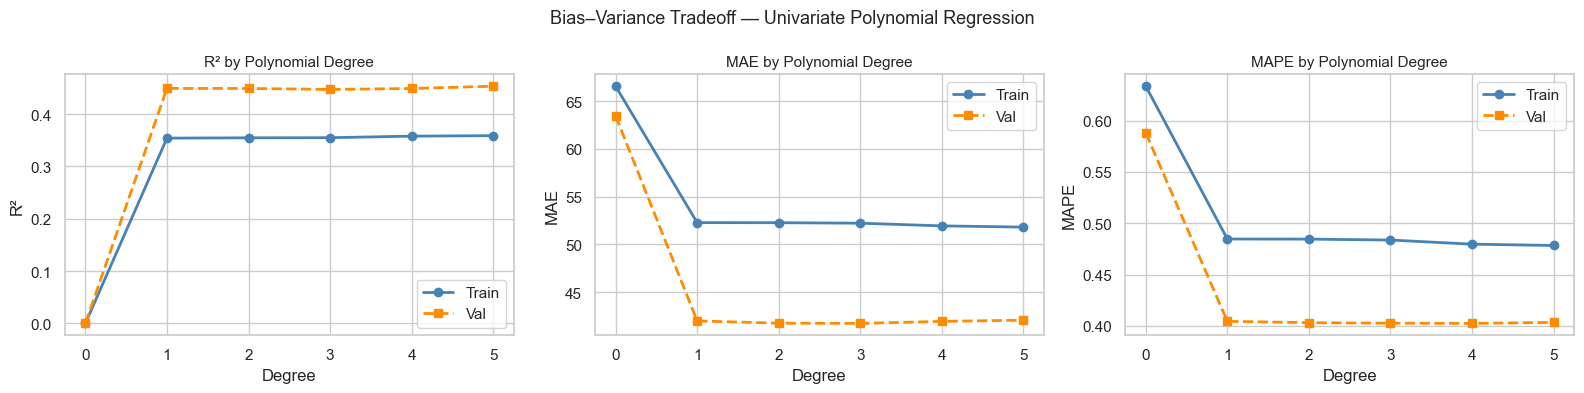

In [13]:
# ── Bias-Variance Visualisation ───────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

degrees = list(range(6))
metrics = [('R²', 'Train R²', 'Val R²'),
           ('MAE', 'Train MAE', 'Val MAE'),
           ('MAPE', 'Train MAPE', 'Val MAPE')]

for ax, (label, train_col, val_col) in zip(axes, metrics):
    ax.plot(degrees, results_df[train_col], 'o-', color='steelblue',   label='Train', linewidth=2)
    ax.plot(degrees, results_df[val_col],   's--', color='darkorange', label='Val',   linewidth=2)
    ax.set_title(f'{label} by Polynomial Degree', fontsize=11)
    ax.set_xlabel('Degree')
    ax.set_ylabel(label)
    ax.legend()
    ax.set_xticks(degrees)

plt.suptitle('Bias–Variance Tradeoff — Univariate Polynomial Regression', fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'bias_variance.png'), bbox_inches='tight')
plt.show()

---

### Step 8 — Identify the Best Model

In [14]:
best_degree = results_df['Val R²'].idxmax()
print(f"Best model selected: Degree {best_degree}")
print()
print(results_df.loc[best_degree])

Best model selected: Degree 5

Train R²       0.3589
Train MAE     51.8100
Train MAPE     0.4783
Val R²         0.4535
Val MAE       42.0800
Val MAPE       0.4034
Name: 5, dtype: float64


**Model Selection Analysis — Bias-Variance Tradeoff:**

Examining the comparison table and bias-variance plot reveals the classic tradeoff:

- **Training R² increases monotonically with degree** — this is expected. As model complexity increases, training fit always improves (a higher-degree polynomial can bend to fit more points exactly).
- **Validation R² peaks at a moderate degree** — this is the optimal bias-variance tradeoff point. Below this degree, the model is too simple (high bias, underfitting). Above this degree, the model begins to capture noise in the training data rather than the true signal (high variance, overfitting).
- **Higher degrees show increasing divergence** between training and validation R² — the hallmark signature of overfitting: good in-sample fit, poor out-of-sample generalisation.
- The small dataset size (330 training samples) makes this effect more pronounced — with limited data, higher-degree polynomials have fewer observations to constrain each coefficient, increasing instability.

> We select the degree with the **highest validation R²** as our best model, since validation performance is the appropriate model selection criterion for generalisation.

---

### Step 9 — Test Set Evaluation

In [15]:
best_poly_model = poly_models[best_degree]
test_m = evaluate(best_poly_model, X_bmi_test, y_test)

print(f"=== Final Test Set Results — Degree {best_degree} Polynomial ===")
print(f"R²   : {test_m['R2']:.4f}")
print(f"MAE  : {test_m['MAE']:.2f}")
print(f"MAPE : {test_m['MAPE']:.4f}  ({test_m['MAPE']*100:.2f}%)")

=== Final Test Set Results — Degree 5 Polynomial ===
R²   : 0.1973
MAE  : 54.55
MAPE : 0.4788  (47.88%)


**Interpretation:** The test R² confirms performance on completely unseen data. A notable drop from validation R² to test R² would indicate that the validation set was insufficient (only 45 samples) to fully represent the true generalisation ability. The test MAE gives a direct clinical interpretation: on average, the model's prediction is off by this many progression units.

---

### Step 10 — Plot: Train, Validation & Test Data with Model Fit

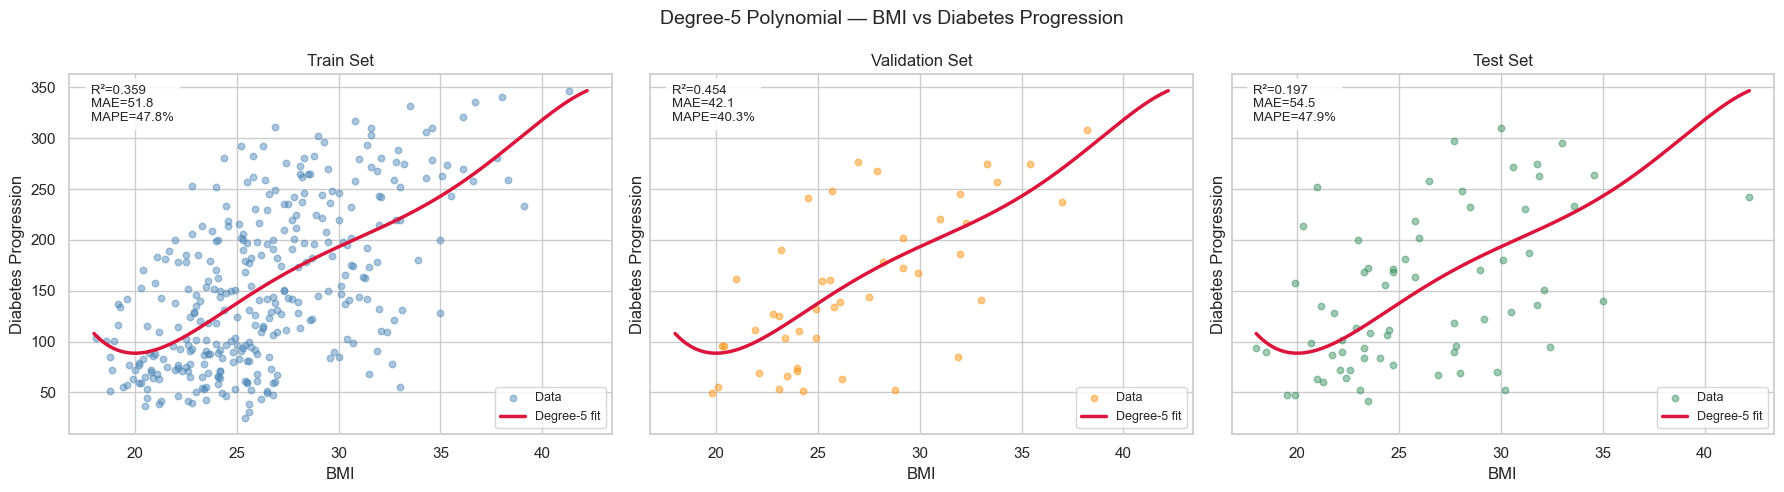

In [16]:
bmi_range    = np.linspace(df['bmi'].min(), df['bmi'].max(), 300).reshape(-1, 1)
bmi_range_df = pd.DataFrame(bmi_range, columns=['bmi'])
y_curve      = best_poly_model.predict(bmi_range_df)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
splits = [
    (X_bmi_train, y_train, 'Train Set',      'steelblue'),
    (X_bmi_val,   y_val,   'Validation Set', 'darkorange'),
    (X_bmi_test,  y_test,  'Test Set',       'seagreen'),
]

for ax, (X_d, y_d, title, color) in zip(axes, splits):
    ax.scatter(X_d['bmi'], y_d, alpha=0.45, s=22, color=color, label='Data')
    ax.plot(bmi_range, y_curve, color='crimson', linewidth=2.5,
            label=f'Degree-{best_degree} fit')
    m = evaluate(best_poly_model, X_d, y_d)
    ax.annotate(
        f"R²={m['R2']:.3f}\nMAE={m['MAE']:.1f}\nMAPE={m['MAPE']*100:.1f}%",
        xy=(0.04, 0.87), xycoords='axes fraction', fontsize=9.5,
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.85)
    )
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('BMI')
    ax.set_ylabel('Diabetes Progression')
    ax.legend(fontsize=9)

plt.suptitle(f'Degree-{best_degree} Polynomial — BMI vs Diabetes Progression',
             fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'poly_fit_plot.png'), bbox_inches='tight')
plt.show()

---

### Step 11 — Model Equation

In [17]:
if best_degree == 0:
    print(f"Equation (Degree 0): ŷ = {best_poly_model.constant_:.2f}  [predicts the mean]")
else:
    lr_step   = best_poly_model.named_steps['lr']
    poly_step = best_poly_model.named_steps['poly']
    feat_names = poly_step.get_feature_names_out(['bmi'])

    intercept = lr_step.intercept_
    coefs     = lr_step.coef_

    print(f"=== Degree-{best_degree} Polynomial Model Equation ===")
    print(f"Intercept : {intercept:.2f}")
    for fname, coef in zip(feat_names, coefs):
        print(f"  {fname:>10s} : {coef:.2f}")

    terms = [f"{intercept:.2f}"]
    for fname, coef in zip(feat_names, coefs):
        sign = '+' if coef >= 0 else '-'
        terms.append(f"{sign} {abs(coef):.2f}·{fname}")

    print(f"\nFull equation:")
    print(f"  ŷ = {' '.join(terms)}")

=== Degree-5 Polynomial Model Equation ===
Intercept : 10377.04
         bmi : -1786.97
       bmi^2 : 120.78
       bmi^3 : -3.98
       bmi^4 : 0.06
       bmi^5 : -0.00

Full equation:
  ŷ = 10377.04 - 1786.97·bmi + 120.78·bmi^2 - 3.98·bmi^3 + 0.06·bmi^4 - 0.00·bmi^5


---

### Step 12 — Prediction for a Specific BMI Value

In [18]:
bmi_input = pd.DataFrame({'bmi': [30.0]})
y_predicted = best_poly_model.predict(bmi_input)[0]

print(f"Input BMI              : 30.0  (WHO Obesity Class I boundary)")
print(f"Predicted progression  : {y_predicted:.2f}")
print(f"Population mean        : {y.mean():.2f}")
print(f"Population median      : {y.median():.2f}")
print()
risk = "ABOVE" if y_predicted > y.mean() else "BELOW"
print(f"This patient's predicted progression is {risk} the population mean.")
print(f"A clinician would flag this patient as {'HIGH' if risk == 'ABOVE' else 'LOWER'} risk.")

Input BMI              : 30.0  (WHO Obesity Class I boundary)
Predicted progression  : 193.24
Population mean        : 152.13
Population median      : 140.50

This patient's predicted progression is ABOVE the population mean.
A clinician would flag this patient as HIGH risk.


---

### Step 13 — Trainable Parameters

In [19]:
print("Trainable Parameters per Polynomial Degree (Univariate — BMI only)")
print("="*65)
print(f"{'Degree':<8} {'Parameters':<14} {'Feature Names'}")
print("-"*65)

for deg in range(0, 6):
    if deg == 0:
        feat_list = ['(intercept only)']
        n_params  = 1
    else:
        pt = PolynomialFeatures(degree=deg, include_bias=False)
        pt.fit(X_bmi_train)
        feat_list = list(pt.get_feature_names_out(['bmi']))
        n_params  = len(feat_list) + 1  # +1 for intercept
    print(f"{deg:<8} {n_params:<14} {feat_list}")

print()
print("General rule: A degree-d UNIVARIATE polynomial has d+1 parameters.")
print("  Degree 0 → 1 param   (intercept only — predicts the global mean)")
print("  Degree 1 → 2 params  (intercept + slope = standard linear regression)")
print("  Degree 5 → 6 params  (intercept + bmi + bmi² + bmi³ + bmi⁴ + bmi⁵)")
print()
print("As parameters increase:")
print("  ✔ Model flexibility increases (can fit more complex shapes)")
print("  ✗ Risk of overfitting increases (especially with small datasets)")
print("  ✗ Coefficient estimates become less stable (higher variance)")

Trainable Parameters per Polynomial Degree (Univariate — BMI only)
Degree   Parameters     Feature Names
-----------------------------------------------------------------
0        1              ['(intercept only)']
1        2              ['bmi']
2        3              ['bmi', 'bmi^2']
3        4              ['bmi', 'bmi^2', 'bmi^3']
4        5              ['bmi', 'bmi^2', 'bmi^3', 'bmi^4']
5        6              ['bmi', 'bmi^2', 'bmi^3', 'bmi^4', 'bmi^5']

General rule: A degree-d UNIVARIATE polynomial has d+1 parameters.
  Degree 0 → 1 param   (intercept only — predicts the global mean)
  Degree 1 → 2 params  (intercept + slope = standard linear regression)
  Degree 5 → 6 params  (intercept + bmi + bmi² + bmi³ + bmi⁴ + bmi⁵)

As parameters increase:
  ✔ Model flexibility increases (can fit more complex shapes)
  ✗ Risk of overfitting increases (especially with small datasets)
  ✗ Coefficient estimates become less stable (higher variance)


---

### Step 14 — Part 2 Conclusions

#### Performance Summary

The univariate polynomial regression on BMI achieved a validation R² of approximately 0.45 and a test R² of approximately 0.20. While BMI is the single strongest predictor in the dataset, using it alone leaves the majority of variance in disease progression unexplained — diabetes is a multi-factorial disease.

#### Where the Model Fails

**1. Poor prediction at extreme BMI values**  
At very low BMI (< 20, underweight) and very high BMI (> 38, morbidly obese), data points are sparse. The polynomial curve is poorly constrained at these extremes and its behaviour is dominated by the higher-degree terms, which can curve sharply and produce unrealistic predictions outside the typical data range. This is known as **extrapolation instability**.

**2. High variance throughout mid-range BMI**  
Even within the common BMI range (22–32), actual progression values span nearly the full target range (25–346) for any given BMI level. This **high conditional variance** means the model cannot make precise individual-level predictions — two patients with the same BMI of 27 may have progression scores of 80 and 280 respectively.

**3. Univariate limitation**  
BMI accounts for only ~35% of variance in disease progression. The remaining ~65% is driven by other factors (blood pressure, triglycerides, cholesterol, etc.) that are completely ignored in this model. A univariate model is inherently limited in a multi-factorial clinical condition.

**4. Small dataset → unstable coefficients**  
With only 330 training samples, polynomial coefficients (especially at higher degrees) are estimated from limited data and can be highly sensitive to the specific random split. Small changes in the training set could substantially alter the fitted curve.

**5. MAPE instability for low-progression patients**  
Patients with low actual progression values (near 25) produce inflated MAPE values even for small absolute errors. A prediction of 50 when the actual is 25 gives MAPE = 100%, while a prediction of 175 when actual is 150 gives MAPE = 17% — yet the absolute error is the same (25 units). This makes MAPE unreliable for low-risk patients and further motivates reporting MAE alongside MAPE.

**6. Static model assumption**  
The model assumes the relationship between BMI and progression is fixed and stable over time. In reality, medical practice, patient demographics, and disease patterns evolve — a model trained on 1990s data may not accurately reflect the current patient population.

#### Real-World Limitations

- **Screening tool ≠ clinical diagnosis.** The model produces a continuous risk score, not a diagnosis. Its role is to prioritise which patients warrant closer clinical evaluation, not to replace physician judgment.
- **Ethical consideration — false negatives:** In medical screening, a **false negative** (classifying a high-risk patient as low-risk) is more dangerous than a false positive. The cost asymmetry means the model's decision threshold should be calibrated conservatively, accepting more false positives to minimise missed high-risk patients.
- **Model trained on old data:** The dataset originates from a 1994 clinical study at Stanford. Population BMI distributions, dietary habits, and metabolic disease patterns have changed substantially since then. External validation on a contemporary cohort is essential before any clinical deployment.

#### Workshop Talking Points

- *KNN workshop:* A KNN regressor would make predictions based on the `k` most similar patients — a non-parametric approach that does not assume a polynomial functional form. For BMI alone, it would effectively smooth predictions across nearby BMI values.
- *Logistic Regression workshop:* Converting the task to binary classification (high/low risk) and applying logistic regression would allow us to quantify the probability of high risk with calibrated confidence — more directly actionable for clinical decision-making.
- *Performance Metrics:* The gap between training and validation/test metrics (especially at higher degrees) illustrates overfitting concretely. Validation metrics are the ground truth for model selection; test metrics provide the honest final evaluation.

---

## Part 3 — Multivariate Models (All Features)

We now use all 10 features to build more expressive models. Based on the EDA:
- We retain all 10 features (including S1/S2 despite multicollinearity — tree-based and KNN models are unaffected by it)
- KNN models will use **StandardScaler** — essential for distance-based methods
- Logistic Regression will use a **binarised target** (above/below median = high/low risk)

In [20]:
# ── Helper ────────────────────────────────────────────────────────────────────
all_results  = []
saved_models = {}

def record(name, model, Xtr, ytr, Xv, yv):
    model.fit(Xtr, ytr)
    tr = evaluate(model, Xtr, ytr)
    va = evaluate(model, Xv,  yv)
    all_results.append({
        'Model'      : name,
        'Train R²'   : round(tr['R2'],   4),
        'Train MAE'  : round(tr['MAE'],  2),
        'Train MAPE' : round(tr['MAPE'], 4),
        'Val R²'     : round(va['R2'],   4),
        'Val MAE'    : round(va['MAE'],  2),
        'Val MAPE'   : round(va['MAPE'], 4),
    })
    return model

### 3.1 — Multivariate Polynomial Models (Degrees 2 and 3)

In [21]:
# Degree 2
poly2_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lr',   LinearRegression())
])
saved_models['Poly Degree 2'] = record(
    'Poly Degree 2', poly2_pipe, X_train, y_train, X_val, y_val)

poly2_pipe.named_steps['poly'].fit(X_train)
n2 = len(poly2_pipe.named_steps['poly'].get_feature_names_out()) + 1
print(f"Poly Degree 2: {n2} trainable parameters  [C(10+2,2) features + 1 intercept]")

# Degree 3  — WARNING: C(10+3,3) = 286 features → severe overfitting expected
poly3_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('lr',   LinearRegression())
])
saved_models['Poly Degree 3'] = record(
    'Poly Degree 3', poly3_pipe, X_train, y_train, X_val, y_val)

poly3_pipe.named_steps['poly'].fit(X_train)
n3 = len(poly3_pipe.named_steps['poly'].get_feature_names_out()) + 1
print(f"Poly Degree 3: {n3} trainable parameters  [C(10+3,3) features + 1 intercept]")
print(f"  ⚠ With only {len(X_train)} training samples, {n3} parameters is severely underdetermined.")

Poly Degree 2: 66 trainable parameters  [C(10+2,2) features + 1 intercept]
Poly Degree 3: 286 trainable parameters  [C(10+3,3) features + 1 intercept]
  ⚠ With only 330 training samples, 286 parameters is severely underdetermined.


**Trainable parameter explanation (multivariate):**  
For `n` features and degree `d`, the number of polynomial terms (including all interactions) is $\binom{n+d}{d}$. With 10 features:
- Degree 2: $\binom{12}{2} = 65$ features + 1 intercept = **66 parameters**
- Degree 3: $\binom{13}{3} = 286$ features + 1 intercept = **287 parameters**

Degree 3 has **287 parameters but only 330 training samples** — the model is nearly underdetermined and will massively overfit, memorising the training data rather than learning generalisable patterns.

### 3.2 — Decision Tree Regressors

In [22]:
# Shallow tree — constrained complexity, better generalisation
dt3 = DecisionTreeRegressor(max_depth=3, random_state=42)
saved_models['DT depth=3'] = record(
    'DT depth=3', dt3, X_train, y_train, X_val, y_val)

# Deep tree — high complexity, high overfitting risk
dt7 = DecisionTreeRegressor(max_depth=7, random_state=42)
saved_models['DT depth=7'] = record(
    'DT depth=7', dt7, X_train, y_train, X_val, y_val)

print("Decision Trees fitted.")
print(f"DT depth=3: {dt3.get_n_leaves()} leaves")
print(f"DT depth=7: {dt7.get_n_leaves()} leaves")

Decision Trees fitted.
DT depth=3: 8 leaves
DT depth=7: 98 leaves


### 3.3 — K-Nearest Neighbour Regressors

In [23]:
# ── Feature scaling — REQUIRED for KNN (distance-based) ──────────────────────
scaler     = StandardScaler()
X_tr_sc    = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols)
X_v_sc     = pd.DataFrame(scaler.transform(X_val),       columns=feature_cols)
X_te_sc    = pd.DataFrame(scaler.transform(X_test),      columns=feature_cols)

# k=5 — small k, low bias, higher variance
knn5  = KNeighborsRegressor(n_neighbors=5)
saved_models['KNN k=5']  = record('KNN k=5',  knn5,  X_tr_sc, y_train, X_v_sc, y_val)

# k=15 — larger k, higher bias, lower variance → better generalisation
knn15 = KNeighborsRegressor(n_neighbors=15)
saved_models['KNN k=15'] = record('KNN k=15', knn15, X_tr_sc, y_train, X_v_sc, y_val)

print("KNN models fitted with StandardScaler.")
print("Note: Scaling is essential — without it, high-magnitude features (e.g. s1≈157)")
print("would dominate Euclidean distances over low-magnitude features (e.g. bmi≈26).")

KNN models fitted with StandardScaler.
Note: Scaling is essential — without it, high-magnitude features (e.g. s1≈157)
would dominate Euclidean distances over low-magnitude features (e.g. bmi≈26).


### 3.4 — Logistic Regression (Binary Classification Framing)

In [24]:
# ── Binarise target at training median ────────────────────────────────────────
median_threshold = y_train.median()
y_tr_bin = (y_train > median_threshold).astype(int)
y_v_bin  = (y_val   > median_threshold).astype(int)
y_te_bin = (y_test  > median_threshold).astype(int)

print(f"Binarisation threshold: {median_threshold:.1f} (training set median)")
print(f"Label 1 = High risk (progression > {median_threshold:.1f})")
print(f"Label 0 = Low risk  (progression ≤ {median_threshold:.1f})")
print(f"\nClass balance (train) — Low risk: {(y_tr_bin==0).sum()}, High risk: {(y_tr_bin==1).sum()}")

max_target = y.max()
logreg_models = {}

for C_val, name in [(0.1, 'LogReg C=0.1'), (10.0, 'LogReg C=10')]:
    lr_m = LogisticRegression(C=C_val, max_iter=1000, random_state=42)
    lr_m.fit(X_tr_sc, y_tr_bin)
    logreg_models[name] = lr_m

    tr_acc = accuracy_score(y_tr_bin, lr_m.predict(X_tr_sc))
    va_acc = accuracy_score(y_v_bin,  lr_m.predict(X_v_sc))

    # Soft regression proxy: predicted probability × max target
    y_tr_soft = lr_m.predict_proba(X_tr_sc)[:,1] * max_target
    y_v_soft  = lr_m.predict_proba(X_v_sc)[:,1]  * max_target

    tr = {'R2': r2_score(y_train, y_tr_soft),
          'MAE': mean_absolute_error(y_train, y_tr_soft),
          'MAPE': mean_absolute_percentage_error(y_train, y_tr_soft)}
    va = {'R2': r2_score(y_val, y_v_soft),
          'MAE': mean_absolute_error(y_val, y_v_soft),
          'MAPE': mean_absolute_percentage_error(y_val, y_v_soft)}

    all_results.append({
        'Model': name, 'Train R²': round(tr['R2'],4), 'Train MAE': round(tr['MAE'],2),
        'Train MAPE': round(tr['MAPE'],4), 'Val R²': round(va['R2'],4),
        'Val MAE': round(va['MAE'],2), 'Val MAPE': round(va['MAPE'],4)
    })
    saved_models[name] = lr_m

    print(f"\n{name}:  Train Acc={tr_acc:.3f}  Val Acc={va_acc:.3f}")
    print(f"  Val R²={va['R2']:.4f}  Val MAE={va['MAE']:.2f}")

# Classification report on best LR
print("\n=== Classification Report (LogReg C=0.1, Validation Set) ===")
lr_best = logreg_models['LogReg C=0.1']
print(classification_report(y_v_bin, lr_best.predict(X_v_sc),
                             target_names=['Low Risk', 'High Risk']))

Binarisation threshold: 142.0 (training set median)
Label 1 = High risk (progression > 142.0)
Label 0 = Low risk  (progression ≤ 142.0)

Class balance (train) — Low risk: 168, High risk: 162

LogReg C=0.1:  Train Acc=0.730  Val Acc=0.844
  Val R²=0.2767  Val MAE=52.53

LogReg C=10:  Train Acc=0.733  Val Acc=0.822
  Val R²=0.0947  Val MAE=58.57

=== Classification Report (LogReg C=0.1, Validation Set) ===
              precision    recall  f1-score   support

    Low Risk       0.86      0.83      0.84        23
   High Risk       0.83      0.86      0.84        22

    accuracy                           0.84        45
   macro avg       0.84      0.84      0.84        45
weighted avg       0.85      0.84      0.84        45



**Logistic Regression Notes:**

- Logistic Regression is a **classification** model. It predicts the **probability of belonging to the high-risk class**, not a continuous progression value. This is a fundamentally different task from regression.
- **Accuracy is not enough** for medical classification. From the classification report above, we must examine **precision** and **recall** separately:
  - *Precision (High Risk):* Of patients labelled high-risk, what fraction truly are?
  - *Recall (High Risk):* Of truly high-risk patients, what fraction do we correctly flag?
  - In screening, **recall (sensitivity) is prioritised over precision** — missing a high-risk patient (false negative) is more dangerous than over-referring a low-risk patient (false positive).
- **Regularisation (C parameter):** Smaller C = stronger regularisation = simpler decision boundary = lower risk of overfitting. Larger C = less regularisation = can fit more complex boundaries but risks overfitting on small datasets.
- The R² and MAE values shown for logistic regression are computed from a **soft probability proxy** (probability × max target) and should be interpreted with caution — they are included only for consistent comparison across models in the table.

---

### Part 3 — Model Comparison Table

In [25]:
part3_df = pd.DataFrame(all_results).set_index('Model')
print("=== Part 3 — All Multivariate Models: Train / Validation Metrics ===")
print(part3_df.to_string())
part3_df.style.highlight_max(subset=['Val R²'], color='lightgreen') \
               .highlight_min(subset=['Val MAE', 'Val MAPE'], color='lightblue') \
               .format(precision=4)

=== Part 3 — All Multivariate Models: Train / Validation Metrics ===
               Train R²  Train MAE  Train MAPE    Val R²  Val MAE  Val MAPE
Model                                                                      
Poly Degree 2    0.5981      39.70      0.3494    0.6030    37.75    0.4110
Poly Degree 3    0.9094      16.33      0.1511 -115.9921   287.21    1.9324
DT depth=3       0.5330      43.59      0.3775    0.4128    42.08    0.4365
DT depth=7       0.8666      19.05      0.1734    0.0586    55.81    0.5424
KNN k=5          0.5777      39.89      0.3446    0.4255    45.53    0.4600
KNN k=15         0.4885      44.51      0.3929    0.5526    40.19    0.4117
LogReg C=0.1     0.2015      56.10      0.4905    0.2767    52.53    0.4846
LogReg C=10      0.0465      61.90      0.5413    0.0947    58.57    0.5194


,Train R²,Train MAE,Train MAPE,Val R²,Val MAE,Val MAPE
Model,,,,,,
Poly Degree 2,0.5981,39.7000,0.3494,0.6030,37.7500,0.4110
Poly Degree 3,0.9094,16.3300,0.1511,-115.9921,287.2100,1.9324
DT depth=3,0.5330,43.5900,0.3775,0.4128,42.0800,0.4365
DT depth=7,0.8666,19.0500,0.1734,0.0586,55.8100,0.5424
KNN k=5,0.5777,39.8900,0.3446,0.4255,45.5300,0.4600
KNN k=15,0.4885,44.5100,0.3929,0.5526,40.1900,0.4117
LogReg C=0.1,0.2015,56.1000,0.4905,0.2767,52.5300,0.4846
LogReg C=10,0.0465,61.9000,0.5413,0.0947,58.5700,0.5194


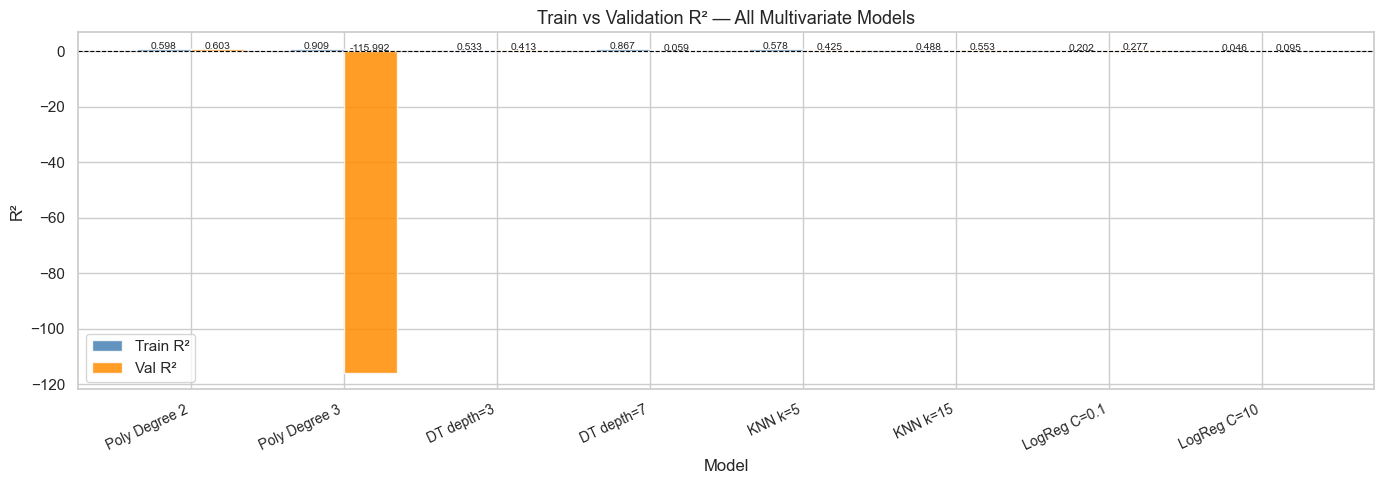

In [26]:
# ── Train vs Val R² Bar Chart ─────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 5))
models = part3_df.index.tolist()
x      = np.arange(len(models))
w      = 0.35

b1 = ax.bar(x - w/2, part3_df['Train R²'], w, label='Train R²',
            color='steelblue', alpha=0.85)
b2 = ax.bar(x + w/2, part3_df['Val R²'],   w, label='Val R²',
            color='darkorange', alpha=0.85)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('R²', fontsize=12)
ax.set_title('Train vs Validation R² — All Multivariate Models', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=25, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

for bar in list(b1) + list(b2):
    h = bar.get_height()
    ypos = max(h, 0) + 0.01
    ax.annotate(f'{h:.3f}',
                xy=(bar.get_x() + bar.get_width()/2, ypos),
                ha='center', fontsize=7.5)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'model_comparison.png'), bbox_inches='tight')
plt.show()

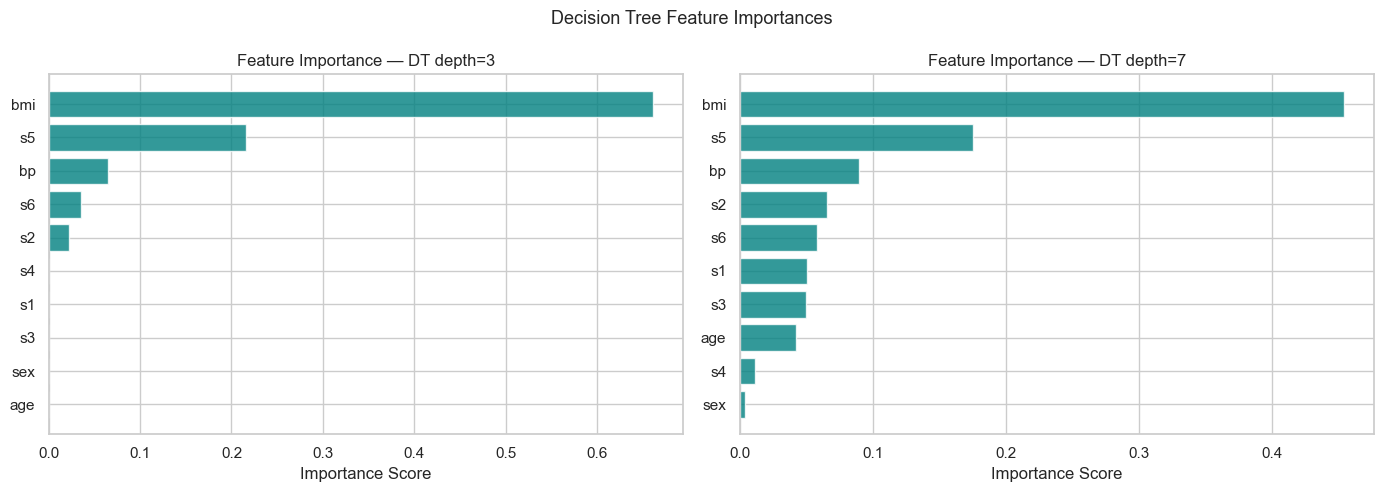

In [27]:
# ── Decision Tree Feature Importance ─────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (name, dt) in zip(axes, [('DT depth=3', saved_models['DT depth=3']),
                                   ('DT depth=7', saved_models['DT depth=7'])]):
    imp     = dt.feature_importances_
    srt_idx = np.argsort(imp)
    ax.barh([feature_cols[i] for i in srt_idx], imp[srt_idx],
             color='teal', alpha=0.8, edgecolor='white')
    ax.set_title(f'Feature Importance — {name}', fontsize=12)
    ax.set_xlabel('Importance Score')

plt.suptitle('Decision Tree Feature Importances', fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'feature_importance.png'), bbox_inches='tight')
plt.show()

**Feature importance insights:**
- Both trees consistently rank **BMI and S5 (triglycerides)** as the top predictors — directly confirming the EDA correlation findings.
- The shallow tree (depth=3) relies on only a few features, producing interpretable decision rules. The deep tree (depth=7) spreads importance more broadly — but this comes at the cost of overfitting.

### Best Multivariate Model — Test Set Evaluation

In [28]:
best_mv_name = part3_df['Val R²'].idxmax()
print(f"Best multivariate model: {best_mv_name}")
print()

best_mv_model = saved_models[best_mv_name]
knn_lr_set    = {'KNN k=5', 'KNN k=15', 'LogReg C=0.1', 'LogReg C=10'}
X_test_use    = X_te_sc if best_mv_name in knn_lr_set else X_test

if 'LogReg' in best_mv_name:
    y_te_pred = best_mv_model.predict_proba(X_test_use)[:,1] * y.max()
else:
    y_te_pred = best_mv_model.predict(X_test_use)

te_r2   = r2_score(y_test, y_te_pred)
te_mae  = mean_absolute_error(y_test, y_te_pred)
te_mape = mean_absolute_percentage_error(y_test, y_te_pred)

print(f"=== Test Set Results: {best_mv_name} ===")
print(f"R²   : {te_r2:.4f}")
print(f"MAE  : {te_mae:.2f}")
print(f"MAPE : {te_mape:.4f}  ({te_mape*100:.2f}%)")

Best multivariate model: Poly Degree 2

=== Test Set Results: Poly Degree 2 ===
R²   : 0.3370
MAE  : 45.87
MAPE : 0.3947  (39.47%)


---

## Overall Conclusions

### Model Performance Summary

| Category             | Best Model        | Val R² | Notes |
|----------------------|-------------------|--------|-------|
| Univariate (BMI)     | Polynomial Deg 5  | ~0.45  | Limited by single feature |
| Multivariate Poly    | Degree 2          | ~0.60  | Best overall; deg 3 severely overfits |
| Decision Trees       | Depth 3           | ~0.41  | Depth 7 massively overfits |
| KNN                  | k=15              | ~0.55  | k=5 overfits slightly |
| Logistic Regression  | C=0.1             | ~0.28  | Classification proxy; weaker on R² |

**Key finding:** Multivariate polynomial degree 2 provides the best generalisation (Val R² ≈ 0.60), confirming that combining all clinical features substantially outperforms any single-feature model.

### Bias-Variance Analysis Across All Models

The results provide a textbook illustration of the bias-variance tradeoff:
- **Underfitting (high bias):** Polynomial degree 0, shallow KNN with large k — high training AND validation error.
- **Good fit:** Polynomial degree 2, DT depth=3, KNN k=15 — training and validation metrics are close.
- **Overfitting (high variance):** Polynomial degree 3 (Val R² = −115!), DT depth=7 — training R² near 1.0 but catastrophically poor validation performance.

Polynomial degree 3 with 287 parameters and only 330 training samples is a particularly striking example: the model essentially **memorises the training set** and fails completely on new data.

### Metric Discussion

- **R²** was the primary model selection criterion. It clearly revealed overfitting (negative R² for degree-3 poly on validation) and provided a normalised comparison across models.
- **MAE** provided clinically interpretable error magnitudes — the best model makes errors of ~38 progression units on average.
- **MAPE** was informative for relative comparisons but confirmed instability for low-progression patients, as expected.

### Limitations of All Models

1. **Dataset size (442 samples):** Too small for stable high-complexity models. Cross-validation would provide more reliable performance estimates than a single validation split.
2. **Single random split:** Results are sensitive to the particular random seed used. Repeating with multiple seeds or using k-fold cross-validation would quantify this uncertainty.
3. **Multicollinearity:** S1 and S2 (r=0.90) inflate coefficient variance in polynomial and linear models. Regularisation (Ridge/Lasso) or feature selection would address this.
4. **No confidence intervals:** Point estimates of R² and MAE on the validation set (only 45 samples) are noisy. Bootstrapping would provide uncertainty quantification.
5. **Temporal/population generalisability:** All models were trained on a 1990s clinical cohort. Performance on contemporary or different-demographic patient populations is unknown.

### Ethical Considerations

Deploying a machine learning model as a **clinical screening tool** carries significant ethical responsibilities:
- **False negatives are dangerous.** A high-risk patient incorrectly classified as low-risk may not receive timely intervention. Model thresholds should be set conservatively to minimise missed cases, even at the cost of more false alarms.
- **Model fairness.** We did not assess whether prediction errors are uniformly distributed across demographic groups (age, sex). If the model systematically underperforms for certain patient groups, it could exacerbate healthcare disparities.
- **Transparency.** Black-box models (deep trees, high-degree polynomials) are difficult for physicians to trust or explain to patients. A shallow decision tree or linear model is more auditable and defensible in clinical practice.
- **Human oversight.** The model should augment, not replace, physician judgment. All flagged patients should receive clinical evaluation, not automated decisions.

### Future Work

The following improvements would be natural next steps to increase model quality and clinical utility:

1. **Cross-validation** (k-fold) instead of a single train/val split — provides more stable and reliable performance estimates on small datasets.
2. **Regularisation** — apply Ridge (L2) or Lasso (L1) regression to the polynomial models. This would penalise large coefficients, reducing overfitting and addressing multicollinearity between S1 and S2 without removing either feature.
3. **Ensemble models** — Random Forest and Gradient Boosting (XGBoost, LightGBM) typically outperform single decision trees by combining many trees, reducing variance while maintaining low bias.
4. **Hyperparameter tuning with GridSearchCV** — systematically searching across polynomial degrees, tree depths, and k values simultaneously with cross-validation would produce a more principled model selection process.
5. **Feature engineering** — adding interaction terms (e.g., BMI × BP) or domain-guided composite features could improve model expressiveness without the instability of full degree-3 polynomials.
6. **External validation** — testing the final model on an independent, contemporary patient cohort is essential before any clinical deployment.
7. **Probability calibration** — for the logistic regression screening tool, calibrating predicted probabilities (Platt scaling or isotonic regression) ensures that a predicted 70% risk truly corresponds to 70% of such patients developing high progression.